# LogRatioEstimator_Ndim

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2
import pylab as plt
import torch
import numpy as np

In [2]:
def logl(u):
    return -0.5*(u**2).sum(axis=-1)/0.1**2

In [3]:
def get_n(B, D):
    t = torch.randn(B, D)
    l = (t**2).sum(axis=-1)**0.5
    n = t/l.unsqueeze(-1)
    return n

In [11]:
D = 2
B = 200

In [12]:
logl_min = -10
l_min = 1e-2

In [13]:
# Initialize
x = torch.randn(B, D)
n = get_n(B, D)
l_init = torch.ones(B, 2)*2
l_init[:,0] *= -1
l = l_init*1
c = torch.zeros(B)
n_steps = 5
logl_th = -1000
ll_list = []

x_list = []
logl_list = []
logl_live = logl(x)
counter = 0
while True:
    counter+=1
    # Propose
    dl = torch.rand(B)*(l[:,1]-l[:,0]) + l[:,0]
    l[dl<0,0] = dl[dl<0]
    l[dl>0,1] = dl[dl>0]
    x_prop = x + dl.unsqueeze(-1)*n
    
    # Accept
    logl_prop = logl(x_prop) 
    accept = logl_prop >= logl_th
    logl_live[accept] = logl_prop[accept]
    x[accept] = x_prop[accept]
    c[accept] += 1
    
    x_new = x[accept & (c%n_steps==1)]
    logl_new = logl_live[accept & (c%n_steps==1)]
    x_list.append(x_new)
    logl_list.append(logl_new)
    
    # Reset
    reset = accept + (l[:,1]<l_min)*(l[:,0]>-l_min)
    n_new = get_n(B, D)
    n[reset] = n_new[reset]
    l[reset] = l_init[reset]
    
    logl_th = min(logl_min, logl_live.min())
    ll_list.append(logl_th)
    replace = logl_live <= logl_th
    if sum(replace) > 0:
        idx_picks = torch.multinomial((~replace).float()+1e-1, sum(replace), replacement = True)
        x[replace] = x[idx_picks]
        logl_live[replace] = logl_live[idx_picks]
        l[replace] = l_init[replace]
        n[replace] = n_new[replace]
    else:
        break
    
x_samples = torch.cat(x_list)
logl_samples = torch.cat(logl_list)

In [14]:
len(x_samples), counter

(23964, 1033)

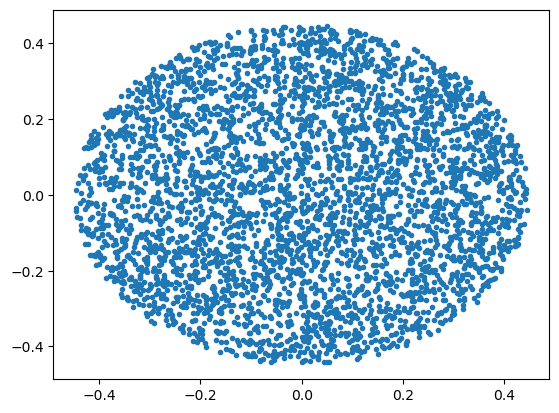

In [15]:
mask = logl_samples > -10
plt.scatter(x_samples[mask,0], x_samples[mask,1], marker='.')

In [9]:
def get_slice_sample_points(N, S):
    hard_bounds = torch.tensor([-1., 1.]).unsqueeze(0).repeat((N,1))
    current_bounds = hard_bounds.clone()
    L = torch.empty((N, S))
    for i in range(S):
        x = torch.rand(N)*(current_bounds[:,1]-current_bounds[:,0])+current_bounds[:,0]
        L[:,i] = x
        current_bounds[x<0,0] = x[x<0]
        current_bounds[x>0,1] = x[x>0]
    return L